In [1]:
from __future__ import print_function
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Genomics example

This will explore how importance scores from three different methods compare on simulated genomic data.

The simulated data was as follows:

- 1/4 sequences with 1-3 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 1,0,0
- 1/4 sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,1,0
- 1/4 sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1
- 1/4 sequences with no motif

Scores for all three tasks for sequences that contain both TAL1_known1 and GATA_disc1 motifs are analyzed in this notebook

### Read in and one-hot encode the data

In [3]:
import gzip
import re
from collections import OrderedDict

def load_sequences(seqfile):
        seqs = OrderedDict()
        fp = gzip.open(seqfile, "rb")
        print("#Loading " + seqfile + " ...")
        expecting = "label"
        label=''
        for line in fp:
                if expecting == "label":
                        match = re.match(">(.*)$", line)
                        if match:
                                label = match.group(1)
                                expecting = "sequence"
                        else:
                                print("Expecting LABEL but found (!!): " + line)
                                continue
                else:
                        match = re.match("(\w+)$", line)
                        if match:
                                sequence = match.group(1)
                                seqs[label]=sequence
                        else:
                                print("Expecting SEQUENCE but found (!!): " + line)
                        expecting = "label"
                        label=''
        fp.close()
        print("#Loaded " + str(len(seqs.keys())) + " sequences from " + seqfile)
        return seqs

In [4]:
def load_sequences_from_bedfile(seqfile):
    seqs = OrderedDict()
    fp = gzip.open(seqfile, "rb")
    print("#Loading " + seqfile + " ...")
    for line in fp:
        (label, sequence)=line.split()
        seqs[label]=sequence
    fp.close()
    print("#Loaded " + str(len(seqs.keys())) + " sequences from " + seqfile)
    return seqs
    

In [5]:
def get_value(label):
    value = -1
    match = re.match("((dinuc_shuff_|dinuc_shuffled_).+)$", label)
    if match:            
        chrom = match.group(1)
        if match.group(2) == 'dinuc_shuff_':
            value = 0
        else:
            value = 1
    return value        

In [6]:
import random
def get_random_set(seqdict, num, sort=True):
    newlist=seqdict.items()
    if sort:
        newlist = [newlist[i] for i in sorted(random.sample(range(len(newlist)), num))]
    else:
        newlist = [newlist[i] for i in random.sample(range(len(newlist)), num)]
    return dict(newlist)

In [8]:
import numpy as np

data_filename_positive = "/users/eprakash/projects/benchmarking/newdata/K562/K562.differential.implanted.bed.gz"
data_filename_negative = "/users/eprakash/projects/benchmarking/newdata/K562/universal_dnase.differential.implanted.bed.gz"
labeled_sequences = load_sequences_from_bedfile(data_filename_positive)
print("Got %d positive sequences" % len(labeled_sequences))
positive_labels = labeled_sequences.keys()
neg_seqs = load_sequences_from_bedfile(data_filename_negative)
neg_seqs = get_random_set(neg_seqs, 200000)
print("Got %d negative sequences" % len(neg_seqs))
negative_labels = neg_seqs.keys()
print("Number of labels common to both sets of sequences is %d " % len(set(positive_labels).intersection(set(negative_labels))))
labeled_sequences.update(neg_seqs)
labeled_sequences=get_random_set(labeled_sequences, 409865, sort=False)
labels = labeled_sequences.keys()
sequences=labeled_sequences.values()
#values = np.array([get_value(label) for label in labels])
#check_negatives = np.nonzero(values == -1)[0]
#assert (len(check_negatives) == 0)
#print("Labels length: ", len(labels))
print("Sequences length: ", len(sequences))
#print("Values length: ", len(values))

#Loading /users/eprakash/projects/benchmarking/newdata/K562/K562.differential.implanted.bed.gz ...
#Loaded 209865 sequences from /users/eprakash/projects/benchmarking/newdata/K562/K562.differential.implanted.bed.gz
Got 209865 positive sequences
#Loading /users/eprakash/projects/benchmarking/newdata/K562/universal_dnase.differential.implanted.bed.gz ...
#Loaded 1027408 sequences from /users/eprakash/projects/benchmarking/newdata/K562/universal_dnase.differential.implanted.bed.gz
Got 200000 negative sequences
Number of labels common to both sets of sequences is 0 
Sequences length:  409865


One-hot encode the data

In [9]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
#sequences = sequences[-5000:]            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in sequences])

In [10]:
print(onehot_data.shape)

(409865, 400, 4)


### Load the keras model

In [11]:
import deeplift
from keras.models import model_from_json

#load the keras model
keras_model_weights = "/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_4NihO_modelWeights.h5"
keras_model_json = "/users/eprakash/git/momma_dragonn/examples/fasta_sequential_model/model_files/record_1_model_4NihO_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

Using TensorFlow backend.


## Prepare the deeplift models

### Model conversion

Convert the keras models to deeplift models capable of computing importance scores using DeepLIFT (with 3 different variants: rescale on the conv layers and revealcancel on the fully-connected layers (the genomics default), rescale on all layers, and revealcancel on all layers), gradients and guided backprop


In [12]:
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
reload(deeplift.layers)
reload(deeplift.conversion.kerasapi_conversion)
from collections import OrderedDict

method_to_model = OrderedDict()
for method_name, nonlinear_mxts_mode in [
    #The genomics default = rescale on conv layers, revealcance on fully-connected
    ('rescale_conv_revealcancel_fc', NonlinearMxtsMode.DeepLIFT_GenomicsDefault),
    ('rescale_all_layers', NonlinearMxtsMode.Rescale),
    #('revealcancel_all_layers', NonlinearMxtsMode.RevealCancel),
    ('grad_times_inp', NonlinearMxtsMode.Gradient)#,
    #('guided_backprop', NonlinearMxtsMode.GuidedBackprop)]:
    ]:
    method_to_model[method_name] = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json,
        nonlinear_mxts_mode=nonlinear_mxts_mode)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 2 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 6 the preceding linear layer is 4 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 10 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 14 the preceding linear layer is 12 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 18 the precedi

### Sanity checks
To ensure that the conversion happend correctly, ensure that the models give identical predictions

If you are using a functional model, see this issue for how to adapt the code: https://github.com/kundajelab/deeplift/issues/54

In [13]:
#make sure predictions are the same as the original model
from deeplift.util import compile_func
model_to_test = method_to_model['rescale_conv_revealcancel_fc']
deeplift_prediction_func = compile_func([model_to_test.get_layers()[0].get_activation_vars()],
                                         model_to_test.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(onehot_data, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[onehot_data],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

maximum difference in predictions: 1.758337e-06


## Compute importance scores

### Compile various scoring functions
Using the deeplift models, we obtain the functions capable of computing the importance scores.

In [14]:
print("Compiling scoring functions")
method_to_scoring_func = OrderedDict()
for method,model in method_to_model.items():
    print("Compiling scoring function for: "+method)
    method_to_scoring_func[method] = model.get_target_contribs_func(find_scores_layer_idx=0,
                                                                    target_layer_idx=-2)
    
#To get a function that just gives the gradients, we use the multipliers of the Gradient model
gradient_func = method_to_model['grad_times_inp'].get_target_multipliers_func(find_scores_layer_idx=0,
                                                                              target_layer_idx=-2)
#print("Compiling integrated gradients scoring functions")
#integrated_gradients10_func = deeplift.util.get_integrated_gradients_function(
#    gradient_computation_function = gradient_func,
#    num_intervals=10)
#method_to_scoring_func['integrated_gradients10'] = integrated_gradients10_func

Compiling scoring functions
Compiling scoring function for: rescale_conv_revealcancel_fc
Compiling scoring function for: rescale_all_layers
Compiling scoring function for: grad_times_inp


### Call scoring functions on the data

In the cell below, a reference representing 40% GC content is used

In [15]:
background = OrderedDict([('A', 0.0), ('C', 0.0), ('G', 0.0), ('T', 0.0)])

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
print (method_to_scoring_func.keys())
for method_name, score_func in method_to_scoring_func.items():
    print("on method",method_name)
    print("scorefunc ", score_func)
    if (not method_name == "grad_times_inp"):
        continue
    method_to_task_to_scores[method_name] = OrderedDict()
    for task_idx in [0]:
        scores = np.array(score_func(
        task_idx=task_idx,
        input_data_list=[onehot_data],
        input_references_list=[
        np.array([background['A'],
                background['C'],
                background['G'],
                background['T']])[None,None,:]],
                batch_size=200,
                progress_update=None))
        assert scores.shape[2]==4
        #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
        # assigns contributions based on difference-from-reference; if
        # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0.3, 0.2, 0.2, 0.3]
        # in the reference, importance will be assigned to the difference (1-0.3)
        # in the 'A' channel, (0-0.2) in the 'C' channel,
        # (0-0.2) in the G channel, and (0-0.3) in the T channel. You want to take the importance
        # on all four channels and sum them up, so that at visualization-time you can project the
        # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
        # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
        # every position and you won't know which base is the one that is actually present in the sequence!
        scores = np.sum(scores, axis=2)
        method_to_task_to_scores[method_name][task_idx] = scores

['rescale_conv_revealcancel_fc', 'rescale_all_layers', 'grad_times_inp']
on method rescale_conv_revealcancel_fc
scorefunc  <function func at 0x7f5fc893ade8>
on method rescale_all_layers
scorefunc  <function func at 0x7f5fc819a2a8>
on method grad_times_inp
scorefunc  <function func at 0x7f5fc819a1b8>


## Using multiple shuffled references

As an alternative to using a flat reference based on GC content (which can sometimes produce artefacts), we propose averaging the scores produced using mutliple references which are produced by shuffling the original sequence. We find in practice that this can give more robust results. Note that in general, the optimal choice of reference is an area of active research.

In [17]:
reload(deeplift.util)
from deeplift.util import get_shuffle_seq_ref_function
#from deeplift.util import randomly_shuffle_seq
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

rescale_conv_revealcancel_fc_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=method_to_scoring_func['rescale_conv_revealcancel_fc'],
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq) for seq in x]))

num_refs_per_seq=10 #number of references to generate per sequence
method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)] = OrderedDict()
for task_idx in [0]:
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
    method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)][task_idx] =\
        np.sum(rescale_conv_revealcancel_fc_many_refs_func(
            task_idx=task_idx,
            input_data_sequences=sequences,
            num_refs_per_seq=num_refs_per_seq,
            batch_size=200,
            progress_update=1000,
        ),axis=2)

1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
9000 reference seqs generated
10000 reference seqs generated
11000 reference seqs generated
12000 reference seqs generated
13000 reference seqs generated
14000 reference seqs generated
15000 reference seqs generated
16000 reference seqs generated
17000 reference seqs generated
18000 reference seqs generated
19000 reference seqs generated
20000 reference seqs generated
21000 reference seqs generated
22000 reference seqs generated
23000 reference seqs generated
24000 reference seqs generated
25000 reference seqs generated
26000 reference seqs generated
27000 reference seqs generated
28000 reference seqs generated
29000 reference seqs generated
30000 reference seqs generated
31000 reference seqs generated
32000 reference seqs generated
33000 reference s

In [18]:
print(method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_10'][task_idx].shape)

(409865, 400)


In [19]:
reload(deeplift.util)
from deeplift.util import get_shuffle_seq_ref_function
#from deeplift.util import randomly_shuffle_seq
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

rescale_all_layers_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=method_to_scoring_func['rescale_all_layers'],
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq) for seq in x]))

num_refs_per_seq=10 #number of references to generate per sequence
method_to_task_to_scores['rescale_all_layers_multiref_'+str(num_refs_per_seq)] = OrderedDict()
for task_idx in [0]:
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
    method_to_task_to_scores['rescale_all_layers_multiref_'+str(num_refs_per_seq)][task_idx] =\
        np.sum(rescale_all_layers_many_refs_func(
            task_idx=task_idx,
            input_data_sequences=sequences,
            num_refs_per_seq=num_refs_per_seq,
            batch_size=200,
            progress_update=1000,
        ),axis=2)

1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
9000 reference seqs generated
10000 reference seqs generated
11000 reference seqs generated
12000 reference seqs generated
13000 reference seqs generated
14000 reference seqs generated
15000 reference seqs generated
16000 reference seqs generated
17000 reference seqs generated
18000 reference seqs generated
19000 reference seqs generated
20000 reference seqs generated
21000 reference seqs generated
22000 reference seqs generated
23000 reference seqs generated
24000 reference seqs generated
25000 reference seqs generated
26000 reference seqs generated
27000 reference seqs generated
28000 reference seqs generated
29000 reference seqs generated
30000 reference seqs generated
31000 reference seqs generated
32000 reference seqs generated
33000 reference s

### Save scores to HDF5 file

In [22]:
import h5py

h5f = h5py.File('/users/eprakash/projects/benchmarking/notebooks/momma_dragonn/universal_dnase.K562.differential.1200K.lr0.0001/K562.universal_dnase.differential_deepliftscores.seqlabels.h5', 'w')
h5f.create_dataset("labels", data=labels)
for meth in method_to_task_to_scores.keys():
    print("Storing scores for " + str(meth))
    h5f.create_dataset(meth, data=method_to_task_to_scores[meth][0])
h5f.close()

Storing scores for grad_times_inp
Storing scores for rescale_conv_revealcancel_fc_multiref_10
Storing scores for rescale_all_layers_multiref_10


## Visualize scores on individual sequences

Visualize the scores at specific sequences. Cyan boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs, red boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs

Scores for task 0 for example 731
[-1.84017885e-03 -2.01749615e-03 -1.38012599e-02  2.30591204e-02
  6.17197827e-02 -9.16312560e-02 -6.62297308e-02  1.04326248e-01
  1.56766176e-01  5.86563200e-02  1.08895734e-01  2.68304765e-01
  3.26384306e-02  2.57761955e-01  4.58664298e-01  3.36818963e-01
  4.40594792e-01  1.02863640e-01  8.55252147e-03  1.53653145e-01
 -1.71461701e-02  8.60846043e-03  4.53037024e-02  2.46049166e-02
  9.05657172e-01  5.25732756e-01  8.43769312e-02  2.28426516e-01
  9.26360488e-03  1.49121821e-01  3.13363433e-01  8.06408226e-02
  2.25749150e-01  2.96734184e-01  8.64866525e-02  3.92408013e-01
  1.29245967e-02  3.49148840e-01  3.09414357e-01  1.59516320e-01
  1.26323029e-01  1.26561493e-01  3.34588289e-02  4.63824123e-01
 -8.48457143e-02  6.79690242e-02 -9.73236561e-03  2.34749615e-01
 -3.34350616e-02 -3.54754478e-02 -1.53434232e-01 -1.17201641e-01
 -1.52793244e-01  5.01744688e-01 -8.75015557e-03 -1.21092796e-02
  2.94254571e-01  2.33440399e-01  2.60796309e-01  8.1619

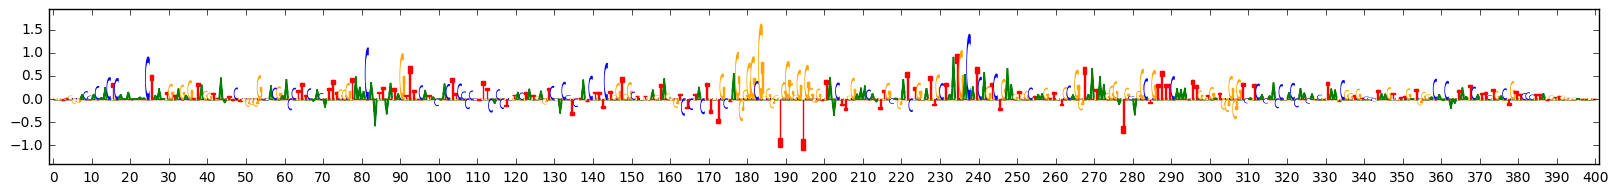

[ 0.00000000e+00 -1.56149804e-03  2.27565691e-03  1.18453233e-02
  1.66763421e-02 -1.95568446e-02 -2.91128438e-02  3.51016372e-02
  2.51836218e-02  1.92747638e-03  4.56518494e-02  6.12763949e-02
 -1.06386971e-02  6.04639128e-02  1.79431647e-01  8.41314495e-02
  1.69359013e-01 -5.51775098e-03 -1.02328151e-01 -2.04290636e-03
 -4.89431433e-02 -8.93229060e-03  2.67939754e-02  2.75925733e-02
  1.37497380e-01  9.26329941e-02  3.00383773e-02  8.41306672e-02
 -4.16118950e-02  5.25471754e-02  1.14156500e-01  3.46219316e-02
  2.64982637e-02  5.39118201e-02  2.93305703e-02  1.14454359e-01
 -2.98257116e-02  5.91830462e-02  6.19992800e-02  5.24155051e-03
  3.30010653e-02  4.38608080e-02  2.43367385e-02  7.02908114e-02
 -5.97807728e-02  7.06479140e-03  1.49322869e-02 -3.63189168e-03
  2.76236217e-02 -5.13326097e-03 -3.84783857e-02 -4.42241654e-02
  4.03226994e-04  6.15223832e-02  2.63496414e-02 -8.50671623e-03
  4.79605384e-02  2.77702566e-02  8.24568979e-03  1.41731650e-02
  4.52828556e-02 -7.10407

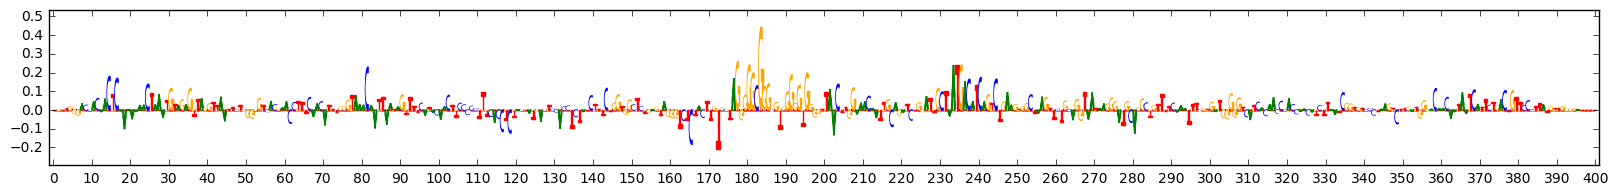

[ 0.00000000e+00 -2.68969545e-03  3.15365195e-03  2.24555191e-02
  3.15963440e-02 -3.74659710e-02 -5.35153709e-02  6.70198351e-02
  5.03420345e-02  3.93823162e-03  8.32381174e-02  1.19093746e-01
 -1.54819693e-02  1.16010621e-01  3.57154816e-01  1.80530384e-01
  3.34516317e-01 -1.72505174e-02 -1.72180861e-01  1.79527756e-02
 -8.11867863e-02 -2.57749930e-02  1.97487883e-02  5.12484685e-02
  3.46453488e-01  1.64415449e-01  6.53217360e-02  1.69814304e-01
 -2.90538706e-02  7.24952966e-02  3.17403913e-01  6.36506230e-02
  5.19910678e-02  1.49313599e-01  1.21540427e-01  3.07186335e-01
 -2.73835231e-02  1.40673220e-01  2.19582438e-01  7.93961138e-02
  7.44459331e-02  9.83078703e-02  4.43293713e-02  2.37981632e-01
 -1.21830210e-01  3.44603062e-02 -6.97195232e-02  3.74837816e-02
  1.19835539e-02  3.80475260e-02 -8.60019475e-02 -1.38244644e-01
 -2.93775816e-02  3.00901771e-01 -1.50409248e-02 -1.84324086e-02
  1.69810012e-01  8.52831602e-02  1.11695886e-01  9.27570239e-02
  2.53768027e-01 -2.16732

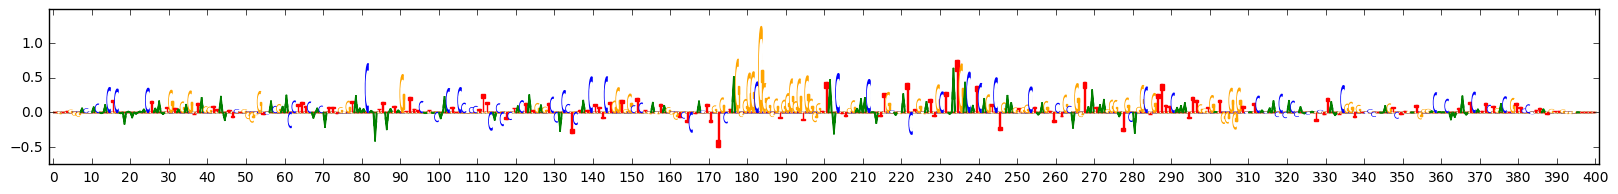

Scores for task 0 for example 197
[ 1.09337959e-02  1.10149607e-02  1.59069672e-02  2.43510827e-02
  6.88144714e-02  5.37897125e-02  2.28508562e-01  1.36525929e-02
  6.21002465e-02 -3.88084054e-02  1.59753069e-01  1.34488672e-01
  9.36674774e-02 -1.31695494e-01  2.40636364e-01  6.53526559e-02
  2.18040213e-01  3.28416616e-01  5.46768904e-02  7.34280795e-02
  2.39184707e-01  1.99020892e-01 -2.94081748e-01  4.81764764e-01
  1.74093902e-01 -2.09150650e-02  1.79143563e-01 -1.36776611e-01
 -6.36222139e-02  1.48911215e-02  1.68509364e-01  1.70518473e-01
 -2.91386023e-02  1.27524599e-01  2.89747715e-01  2.31715888e-02
 -3.85461450e-02  1.02466896e-01  2.45845884e-01  5.74953735e-01
  2.11965218e-01  1.29650533e-01 -1.86403394e-02  4.03400779e-01
  2.15631872e-01  1.88328147e-01  3.45547408e-01  2.83355027e-01
  1.37054592e-01 -8.91292095e-03  4.93242353e-01  1.81967616e-01
  4.00672078e-01  1.42053366e-01  3.21940064e-01  5.98855138e-01
  5.53432465e-01 -4.19918597e-02  1.15673602e-01 -1.3517

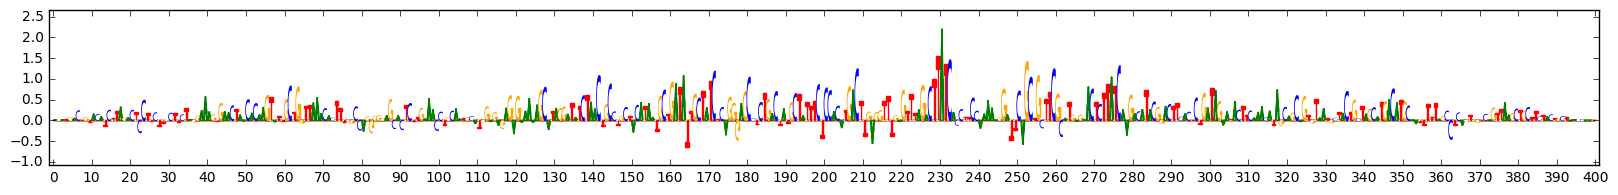

[ 0.00000000e+00  5.96245192e-03  1.08991412e-03  2.34867586e-03
  1.71243399e-02  1.13686975e-02  8.79783183e-02 -9.01581254e-03
 -7.87224341e-03 -1.68689098e-02  5.36875352e-02  6.16558129e-03
  5.24086924e-03 -8.38667750e-02  1.09524027e-01  1.60397533e-02
  5.93925416e-02  4.12532426e-02 -3.11476178e-02  3.39827947e-02
  5.04460447e-02  6.99568167e-02 -5.58465607e-02  9.36418176e-02
  6.04625195e-02  3.73484865e-02  7.48823583e-03 -3.47008817e-02
 -6.28140406e-04 -2.09808331e-02  1.52353151e-03  6.69583380e-02
 -3.19432989e-02  3.63334641e-02  9.55186635e-02 -6.62507303e-03
 -4.71562110e-02  5.29443026e-02  6.06939271e-02  1.11505002e-01
  3.51368710e-02  9.19305086e-02  9.36437491e-03  1.24794476e-01
  6.01956919e-02  6.46972433e-02  1.21068522e-01  5.15390113e-02
 -1.30985379e-02 -9.67616122e-03  1.13883853e-01 -1.41514055e-02
  8.99118334e-02  4.64717224e-02  7.61108622e-02  1.40256748e-01
  1.67619362e-01 -1.97298825e-03  2.27365121e-02  3.70823555e-02
  1.05116099e-01  1.51311

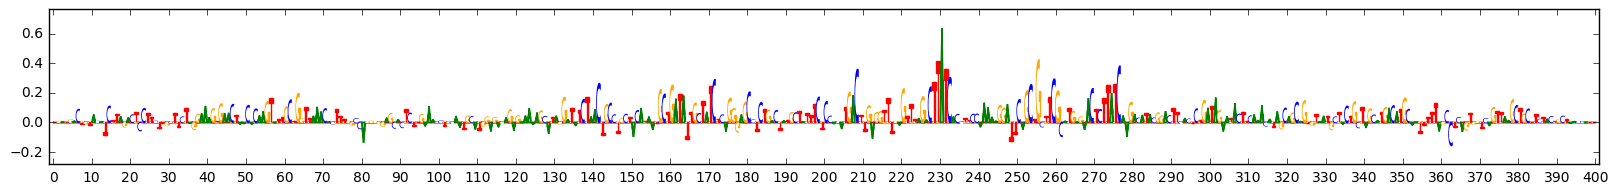

[ 0.00000000e+00  9.84162558e-03  2.34332005e-03  3.54632363e-03
  2.65559070e-02  1.67129841e-02  1.48577332e-01 -1.67584904e-02
 -1.25796059e-02 -2.64914557e-02  8.33282098e-02  1.59173682e-02
  1.51266251e-02 -1.41630322e-01  1.78855747e-01  2.59492621e-02
  9.09554958e-02  6.42200783e-02 -2.32137349e-02  8.84222984e-02
  1.10106513e-01  1.15071401e-01 -1.06983215e-01  1.86272323e-01
  1.08944543e-01  5.39462976e-02  1.23297274e-02 -2.62290090e-02
 -2.33585741e-02 -1.82682015e-02  2.67061666e-02  1.54573888e-01
 -4.62136120e-02  6.86383247e-02  1.83809996e-01 -4.66626957e-02
 -3.90139520e-02  1.48253888e-01  1.46795347e-01  2.48179525e-01
  1.16720498e-01  1.44265652e-01 -4.36414592e-02  1.92527860e-01
  1.14888743e-01  1.72778383e-01  2.78380066e-01  1.32980958e-01
  1.13371573e-02  2.75165755e-02  3.48992646e-01  1.34399295e-01
  1.90772548e-01  7.55254850e-02  2.20083192e-01  3.34025145e-01
  3.81773949e-01 -2.37193555e-02  2.98965313e-02  5.94075769e-02
  2.21350580e-01  3.89988

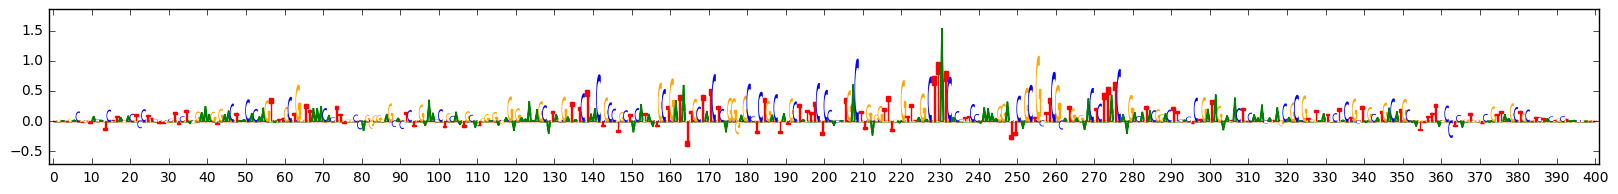

In [23]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence

for task, idx in [(0,731), #illustrates failure of grad*inp, integrated grads, deeplift-rescale
                  (0,197)  #illustrates non-specific firing of guided backprop
                 ]:
    print("Scores for task",task,"for example",idx)
    for method_name in [
                        'grad_times_inp',
                        #'integrated_gradients10',
                        #'rescale_all_layers',
                        #'rescale_conv_revealcancel_fc',
                        'rescale_conv_revealcancel_fc_multiref_10',
                        'rescale_all_layers_multiref_10'
                        ]:
        scores = method_to_task_to_scores[method_name][task]
        scores_for_idx = scores[idx]
        print(scores_for_idx)
        original_onehot = onehot_data[idx]
        scores_for_idx = original_onehot*scores_for_idx[:,None]
        print(method_name)
 #       highlight = {'blue':[
 #               (embedding.startPos, embedding.startPos+len(embedding.what))
 #               for embedding in data.embeddings[idx] if 'GATA_disc1' in embedding.what.getDescription()],
 #               'green':[
 #               (embedding.startPos, embedding.startPos+len(embedding.what))
 #               for embedding in data.embeddings[idx] if 'TAL1_known1' in embedding.what.getDescription()]}
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight={})

## Making the scatterplots

I haven't ported the code necessary to generate the scatterplots in the DeepLIFT paper in this version of DeepLIFT. However, for a notebook that reproduces the figures in the paper, feel free to look at https://github.com/kundajelab/deeplift/blob/671ee67a03bd5bebf4c405af59eec45d3ca2a288/examples/public/genomics/genomics_simulation.ipynb